In [1]:
import os
os.chdir('../')
from helpers import *

mousenums:  ['230', '355', '358', '362', '673', '674', '816', '825']


In [2]:
mousenums = ['230', '355', '362', '673', '674', '816', '825']

In [3]:
timeBefore = 20
timeAfter = 40
enterSide = np.zeros((0, timeBefore + timeAfter))
exitSide = np.zeros((0, timeBefore + timeAfter))
cta = []
traces_all = []
epm_mpos_examples = [None]*3
epm_calc_examples = [None]*3
example_traces = [None]*3
example_mpos = [None]*3
mpos_all = []
cc = 0
for mouse in ['230', '355', '362', '673', '674', '816', '825']:
    track1, neur1, behav1 = getdicts(foldnames, mouse, 'epm')
    track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
    calc1, calc2 = getcalcs(foldnames, mouse, 'epm', 'rat1')
    calc1 = zscore(calc1)
    calc2 = zscore(calc2)
    
    mpos1 = rescale_epm_mpos(track1['mouse_positionMS'], behav1)
    mpos2 = track2['mouse_positionMS']
    mpos2[:, 0] = minmaxscale(mpos2[:, 0], vmin=0, vmax=1)
    mpos2[:, 1] = minmaxscale(mpos2[:, 1], vmin=0, vmax=1)
    
    isNear = (mpos2[:, 0] > 0.2)
    toside = np.zeros(mpos2.shape[0])
    toside[1:] = np.diff(isNear.astype('int'))
    toside[0:timeBefore] = 0
    toside[-timeAfter:] = 0
    
    enterSideInd = np.nonzero(toside == -1)[0]
    exitSideInd = np.nonzero(toside == 1)[0]
    
    Lmin = 15 # 15 frames = 2s
    
    numCells = calc2.shape[1]
    for cell in range(numCells):
        traces = np.zeros((enterSideInd.size, timeBefore+timeAfter))
        for k in range(enterSideInd.size):
            trace = calc2[enterSideInd[k] - timeBefore: enterSideInd[k] + timeAfter, cell]
            traces[k] = trace
        tracemean = np.mean(traces, axis = 0).reshape((1, timeBefore+timeAfter))
        enterSide = np.vstack((enterSide, tracemean))
        
        traces = np.zeros((exitSideInd.size, timeBefore+timeAfter))
        mpos_trace = np.zeros((exitSideInd.size, timeBefore+timeAfter, 2))
        c = 0
        for k in range(exitSideInd.size):
            ind = exitSideInd[k]
            trace = calc2[exitSideInd[k] - timeBefore: exitSideInd[k] + timeAfter, cell]
            mp_trace = mpos2[exitSideInd[k] - timeBefore: exitSideInd[k] + timeAfter, :]
            if np.sum(isNear[ind:ind+Lmin]) == 15:
                traces[c] = trace
                mpos_trace[c] = mp_trace
                c += 1
        traces = traces[0:c]
        mpos_trace = mpos_trace[0:c]
        
        ct = celltypebehav(calc1[:, cell], behav1)
        if mouse == '355' and cell == 10: # originally 0
            example_traces[0] = traces # closed
            example_mpos[0] = mpos_trace
            epm_mpos_examples[0] = mpos1.copy()
            epm_calc_examples[0] = calc1[:, cell]
            print('closed', ct)
        if mouse == '355' and cell == 8:
            example_traces[1] = traces # neither
            example_mpos[1] = mpos_trace
            epm_mpos_examples[1] = mpos1.copy()
            epm_calc_examples[1] = calc1[:, cell]
            print('neither', ct)
        if mouse == '355' and cell == 6: # 13 may be a better example
            example_traces[2] = traces # open
            example_mpos[2] = mpos_trace
            epm_mpos_examples[2] = mpos1.copy()
            epm_calc_examples[2] = calc1[:, cell]
            print('open', ct)
        mpos_all.append(mpos_trace)
        traces_all.append(traces)
        
        
        tracemean = np.mean(traces, axis = 0).reshape((1, timeBefore+timeAfter))
        exitSide = np.vstack((exitSide, tracemean))
        cta.append(ct)
        cc += 1
    print(mouse, numCells, traces.shape, exitSideInd.size)
cta = np.array(cta)

230 17 (32, 60) 34
open o
neither n
closed c
355 30 (28, 60) 38
362 37 (73, 60) 103
673 51 (11, 60) 12
674 39 (16, 60) 16
816 78 (32, 60) 33
825 65 (18, 60) 18


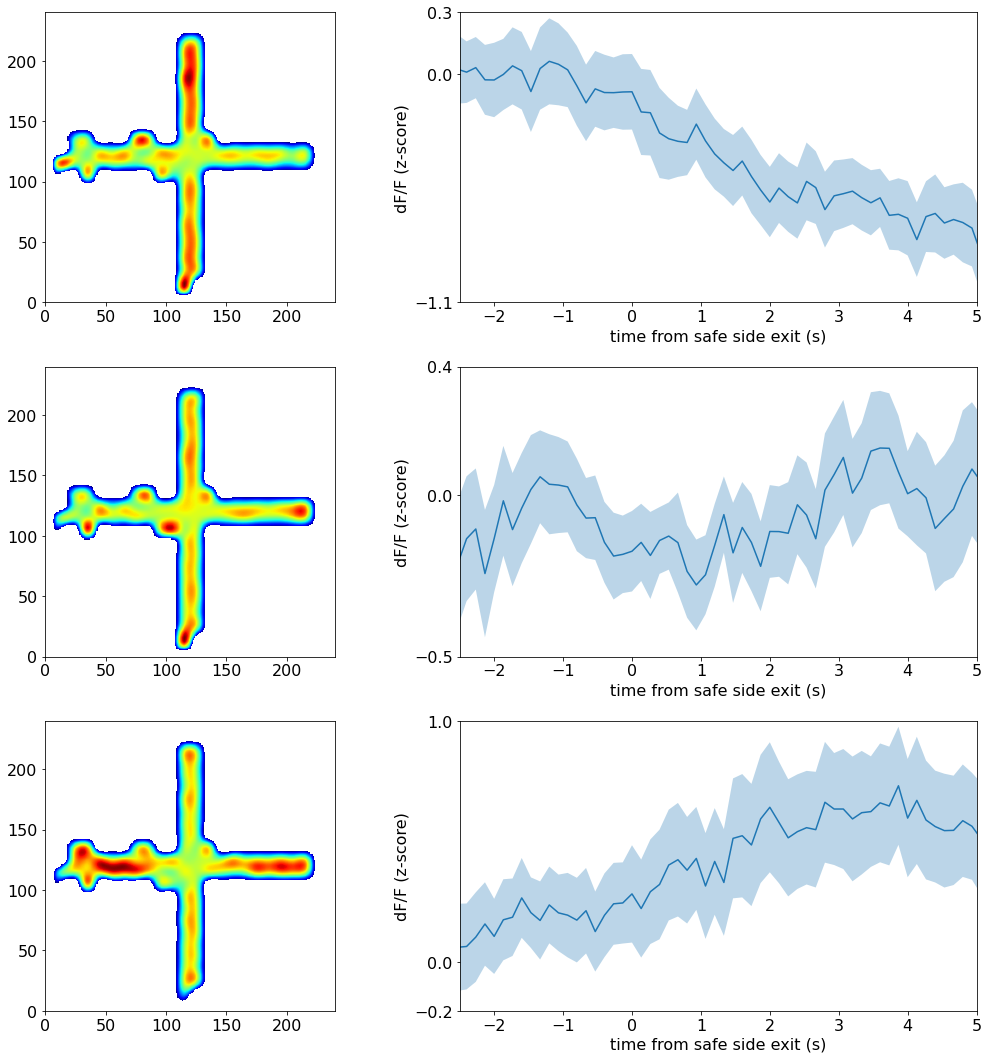

In [4]:
plt.figure(figsize=(15, 15))
for i in range(3):
    plt.subplot(3, 2, 1+2*i)
    ax = plt.gca()
    _ = plotheatmap(epm_mpos_examples[i], epm_calc_examples[i], ax = ax, step=0.10, interpstep=0.01)

t = np.arange(-20, 40)/7.5
ylims = [[-1.1, 0.3], [-0.5, 0.4], [-0.2, 1.0]]
for i in range(3):
    c = ['r', 'b', 'g'][i]
    mu = np.mean(example_traces[i], axis=0)
    err = sem(example_traces[i], axis=0)
    plt.subplot(3, 2, 2+2*i)
    _ = plt.plot(t, mu)
    plt.fill_between(t, mu-err, mu+err, zorder=-1, alpha=0.3)
    
    
    plt.xlim(-2.5, 5)
    plt.ylim(ylims[i])
    plt.yticks(ylims[i] + [0])
    plt.xlabel('time from safe side exit (s)')
    plt.ylabel('dF/F (z-score)')
plt.tight_layout()
plt.savefig('./elife_figs/3s3A.svg')

In [5]:
from scipy.stats import wilcoxon

In [6]:
t[5], t[46]

(-2.0, 3.466666666666667)

In [7]:
wilcoxon(example_traces[0][:, 46], example_traces[0][:, 5])

WilcoxonResult(statistic=103.0, pvalue=0.02277772703207994)

In [8]:
wilcoxon(example_traces[2][:, 46], example_traces[2][:, 5])

WilcoxonResult(statistic=115.0, pvalue=0.04508235295510378)

In [9]:
for i, typ in enumerate(['o', 'n', 'c']):
    print(np.sum(cta == typ))

64
166
87


RanksumsResult(statistic=3.2910209609659495, pvalue=0.0009982447480188928)


Text(0, 0.5, 'Δ dF/F (after - before)')

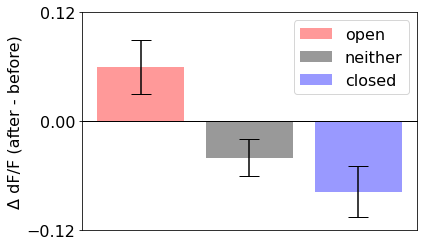

In [10]:
colors = ['r', 'k', 'b']
diffs = []
for i, typ in enumerate(['o', 'n', 'c']):
    diff = np.mean(exitSide[cta == typ][:, 20:39], axis=1) - np.mean(exitSide[cta == typ][:, 1:20], axis=1)
    diffs.append(diff)
    plt.bar(i, np.mean(diff), color=colors[i], alpha=0.4)
print(ranksums(diffs[0], diffs[2]))
plt.legend(['open', 'neither', 'closed'])
for i, typ in enumerate(['o', 'n', 'c']):
    diff = np.mean(exitSide[cta == typ][:, 20:39], axis=1) - np.mean(exitSide[cta == typ][:, 1:20], axis=1)
    plt.errorbar(i, np.mean(diff), sem(diff), fmt='k_', ms=0, capsize=10)
plt.plot(0, 0, 'k_', ms=2000)
plt.ylim(-0.12, 0.12)
plt.yticks([-0.12, 0, 0.12])
plt.xticks([])

plt.ylabel('Δ dF/F (after - before)')
plt.savefig('./elife_figs/3H.svg')

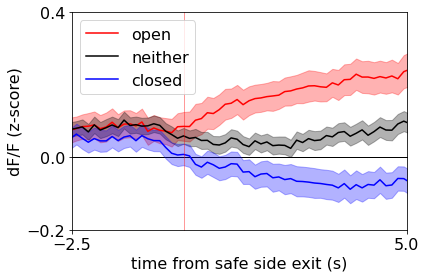

In [11]:
t = np.arange(-20, 40)/7.5
for i, typ in enumerate(['o', 'n', 'c']):
    tracemu = np.mean(exitSide[cta==typ], axis=0)
    tracesem = sem(exitSide[cta==typ], axis=0)
    plt.fill_between(t, tracemu-tracesem, tracemu+tracesem, color=colors[i], alpha=0.3, zorder=-1)
    plt.plot(t, tracemu, color=colors[i])
plt.legend(['open', 'neither', 'closed'])
plt.ylim(-0.2, 0.4)
plt.yticks([-0.2, 0, 0.4])
plt.xlim(-2.5, 5)
plt.xticks([-2.5, 5])
plt.xlabel('time from safe side exit (s)')
plt.ylabel('dF/F (z-score)')
plt.plot(0, 0, 'r|', ms=2000, alpha=0.4)
plt.plot(0, 0, 'k_', ms=2000, zorder=-2)

plt.savefig('./elife_figs/3G.svg')